# Where Should You Move?
### Analyzing Census and Tax Data with Python
---
#### Riaz Islam and Phil Schroder
#### May 14, 2020
---

## Section 1: Data Gathering

To start, we looked to gather zip code level data from the Census website. Using the advanced search functionality, we were able to pull a number of CSV tables. Each table was comprised of 100 to 750 metrics for each zip code. There are currently over 41,000 zip codes in the US, but most census tables have roughly 35,000 rows of available data. Our sample grew even smaller as we cleansed our data, but the end result was still robust. In the end, we conducted our analysis on a sample of roughly 25,000 of the most populous zip codes in the country. In addition to census data we used publically available IRS tax tables to further enhance our data set. We also added geographical data such as latitude and longitude to enable geo-mapping. We considered adding in weather and political demographic data as well, but ran into constraints in terms of time and money. Finding zip-code level data for these topics either involves cobbling together many disparate sources or paying for access. Regardless, we feel the dataset we created was sufficient for our purposes. The CSV files can be found in the Githib repository or online using the following URLS:

Census: https://data.census.gov/cedsci/

IRS:https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi

Geography: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/

---

## Stection 2: Load Data and Create Master DataFrame

After our data had been secured, it was time to load it into Python and merge it together. First, we took a look at the metadata files for each table to get a feel for the columns we would want in our final table. We pared down the list of over 2,000 metrics into a short list of roughly 100. Then we took the metadata's column codes and put them into dictionaries to help us manage the size of the files we loaded into dataframes. To ensure validity, we cleansed and standardized our data before and after joining. Starting with the geographical data table, we joined every CSV together using a left join. This resulted in an initial master data frame.

In [1]:
# Importing useful functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from collections import OrderedDict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
#Prepare to Load all numeric data

#Create path for loading data
path = 'C:/Users/Philip Schroder/Desktop/NYU MBA 2/7. Data Bootcamp/Final Project/Data/'
# Phil's path: 'C:/Users/Philip Schroder/Desktop/NYU MBA 2/7. Data Bootcamp/Final Project/Data/'
# Riaz's path: 'C:\\Users\\riazu\\Google Drive\\Data Bootcamp\\Data Bootcamp Project\\Data Files Mk II\\Data\\'

#Create lists for loading data
filename_list = ['Education_Stats_by_Zip.csv','Ethnicity_Stats_by_Zip.csv',
                 'Housing_Stats_by_Zip.csv','Income_Stats_by_Zip.csv','Population_Stats_by_Zip.csv',
                 'Tax_Stats_by_Zip.csv']
data_list = ['education', 'ethnicity', 'housing', 'income', 'population', 'tax']

#Create dictionary for storing data
filename_dictionary = {'education': 'Education_Stats_by_Zip.csv',
                       'ethnicity': 'Ethnicity_Stats_by_Zip.csv',
                       'housing': 'Housing_Stats_by_Zip.csv',
                       'income': 'Income_Stats_by_Zip.csv',
                       'population': 'Population_Stats_by_Zip.csv',
                       'tax': 'Tax_Stats_by_Zip.csv'}

#Create dictionary for choosing columns to load
columns_to_pull = {'education': ['Zip', 'S1501_C01_006E', 'S1501_C02_007E', 'S1501_C02_013E', 'S1501_C02_014E', 
                                 'S1501_C02_015E'],
                   'ethnicity': ['Zip', 'B01001A_001E'],
                   'housing': ['Zip', 'DP04_0016E', 'DP04_0017E', 'DP04_0037M', 'DP04_0057E', 'DP04_0089E', 'DP04_0134E',
                               'DP04_0020E', 'DP04_0021E', 'DP04_0022E', 'DP04_0023E', 'DP04_0024E', 'DP04_0025E',
                               'DP04_0026E', 'DP04_0046E', 'DP04_0047E', 'DP04_0109E'],
                   'income': ['Zip', 'S1901_C01_012E'],
                   'population': ['Zip', 'S0101_C01_001E', 'S0101_C01_002E', 'S0101_C01_003E', 'S0101_C01_004E', 
                                  'S0101_C01_005E', 'S0101_C01_015E', 'S0101_C01_016E', 'S0101_C01_017E', 
                                  'S0101_C01_018E', 'S0101_C01_019E', 'S0101_C01_032E', 'S0101_C01_033E'],
                   'tax': ['ZIPCODE', 'N1', 'A00100', 'N20950', 'N06500', 'A06500', 'A02650', 'A04800', 'A10600',
                           'A18425', 'A18450', 'A18500', 'A18800', 'A19700', 'N03300']}

In [3]:
#Load geographic descriptor columns as an initial dataframe and cleanse it (non-numeric columns)
zips=path+'Geo_Data_by_Zip.csv'
zip_columns=['zip', 'type', 'decommissioned', 'primary_city', 'state', 'area_codes', 'country', 'latitude', 'longitude']
zip_df=pd.read_csv(zips, usecols=zip_columns, error_bad_lines=False)
zip_df=zip_df.loc[zip_df['country']=='US'].rename(columns={'zip': 'Zip'})
zip_df.head(5)

,Zip,type,decommissioned,primary_city,state,area_codes,country,latitude,longitude
0,501,UNIQUE,0,Holtsville,NY,631,US,40.81,-73.04
1,544,UNIQUE,0,Holtsville,NY,631,US,40.81,-73.04
2,601,STANDARD,0,Adjuntas,PR,"787,939",US,18.16,-66.72
3,602,STANDARD,0,Aguada,PR,"787,939",US,18.38,-67.18
4,603,STANDARD,0,Aguadilla,PR,787,US,18.43,-67.15


We noticed a number of nulls and errant values in our data. The code below does a first pass at data standardization.

In [4]:
#Create single dictionary with all files
#https://stackoverflow.com/posts/30638956/revisions
#https://www.w3schools.com/python/python_dictionaries.asp

files = {}
for file in data_list:
    filepath = path+filename_dictionary[file]
    files[file] = pd.read_csv(filepath, usecols=columns_to_pull[file], error_bad_lines=False)
    files[file] = files[file].replace('\\N',np.nan)
    files[file] = files[file].replace('Null',np.nan)
    files[file] = files[file].replace('(X)',np.nan)
    files[file] = files[file].replace('N',np.nan)
    files[file] = files[file].replace('-',np.nan) 
    files[file] = files[file].replace('**',np.nan) 
    files[file] = files[file].replace('***',np.nan) 
    files[file] = files[file].replace('2,000,000+',2000000) 
    files[file] = files[file].replace('250,000+',250000) 
    files[file] = files[file].replace('3,500+',3500) 
    files[file] = files[file].replace('1,500+',1500) 
    files[file] = files[file].replace('100-',100) 
    
for column in columns_to_pull[file]:
    pd.to_numeric(files[file][column], errors='coerce')

C:\Users\Philip Schroder\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (612,684,696,708) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#standardize zip code column in tax as 'Zip'
files['tax']=files['tax'].rename(columns={'ZIPCODE':'Zip'})

After cleaning each table we joined everything together. The file starts with the geo data and left joins the other tables using a for loop. This results in a singular table that organizes all metrics by zip. 

In [6]:
# Merge every dataframe together into a master
master_data = zip_df.merge(files['education'], on='Zip', how='left')

for key in data_list[1:len(data_list)]:
    master_data = master_data.merge(files[key], on='Zip', how='left')

master_data.head(3)

,Zip,type,decommissioned,primary_city,state,area_codes,country,latitude,longitude,S1501_C01_006E,...,A18425,A18450,A18500,A18800,A19700,N20950,A04800,A10600,N06500,A06500
0,501,UNIQUE,0,Holtsville,NY,631,US,40.81,-73.04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,544,UNIQUE,0,Holtsville,NY,631,US,40.81,-73.04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,601,STANDARD,0,Adjuntas,PR,"787,939",US,18.16,-66.72,11838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
master_data.shape

(42263, 58)

In [8]:
master_data.dtypes

Zip                 int64
type               object
decommissioned      int64
primary_city       object
state              object
area_codes         object
country            object
latitude          float64
longitude         float64
S1501_C01_006E    float64
S1501_C02_007E     object
S1501_C02_013E     object
S1501_C02_014E     object
S1501_C02_015E     object
B01001A_001E      float64
DP04_0016E        float64
DP04_0017E        float64
DP04_0020E        float64
DP04_0021E        float64
DP04_0022E        float64
DP04_0023E        float64
DP04_0024E        float64
DP04_0025E        float64
DP04_0026E        float64
DP04_0037M         object
DP04_0046E        float64
DP04_0047E        float64
DP04_0057E        float64
DP04_0089E         object
DP04_0109E         object
DP04_0134E         object
S1901_C01_012E     object
S0101_C01_001E    float64
S0101_C01_002E    float64
S0101_C01_003E    float64
S0101_C01_004E    float64
S0101_C01_005E    float64
S0101_C01_015E    float64
S0101_C01_01

In [9]:
for key in data_list:
    print(key)
    print(files[key].shape)

education
(33120, 6)
ethnicity
(33120, 2)
housing
(33120, 17)
income
(33120, 2)
population
(33120, 13)
tax
(27760, 15)


We looked at the master data frame and noticed a number of rows were sparsely populated. We decided to drop rows with null values to prevent problems in our analysis down the line.

In [10]:
#Drop rows with NaNs; this will only keep Zip Codes with relevant data
master_data_drop_na = master_data.dropna(axis=0, how='any')

In [11]:
master_data_drop_na.head(5)

,Zip,type,decommissioned,primary_city,state,area_codes,country,latitude,longitude,S1501_C01_006E,...,A18425,A18450,A18500,A18800,A19700,N20950,A04800,A10600,N06500,A06500
194,1001,STANDARD,0,Agawam,MA,413,US,42.06,-72.61,13508.0,...,14943.0,139.0,10826.0,743.0,5396.0,130.0,369108.0,74790.0,7130.0,58115.0
195,1002,STANDARD,0,Amherst,MA,413,US,42.37,-72.52,13857.0,...,34012.0,248.0,31450.0,874.0,15930.0,50.0,639691.0,144450.0,7260.0,122526.0
198,1005,STANDARD,0,Barre,MA,978,US,42.42,-72.10,3569.0,...,3924.0,45.0,3477.0,226.0,1199.0,30.0,97410.0,18866.0,1890.0,14513.0
199,1007,STANDARD,0,Belchertown,MA,413,US,42.27,-72.40,10120.0,...,19698.0,102.0,17238.0,1010.0,5586.0,90.0,407175.0,82767.0,6190.0,68685.0
200,1008,STANDARD,0,Blandford,MA,413,US,42.18,-72.93,949.0,...,1232.0,0.0,1107.0,74.0,330.0,0.0,29974.0,5740.0,530.0,4657.0


In [12]:
master_data_drop_na.shape

(23918, 58)

Our columns listed metrics by code. We build a dictionary to replace these codes with simple names in an effort to make our data frame easier to understand and work with.

In [13]:
#Rename columns
#https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html

rename_dictionary = {'S1501_C01_006E': 'Population_above_25',
                     'S1501_C02_007E': 'Percent_pop_less_than_high_school_education',
                     'S1501_C02_013E': 'Percent_pop_graduate_or_professional_degree',
                     'S1501_C02_014E': 'Percent_pop_high_school_degree_plus',
                     'S1501_C02_015E': 'Percent_pop_bachelor_degree_plus',
                     'B01001A_001E': 'Total_White_Population',
                     'DP04_0016E': 'Total_housing_units',
                     'DP04_0017E': 'Houses_built_14_or_later',
                     'DP04_0037M': 'Median_rooms_in_household',
                     'DP04_0057E': 'Vehicles_per_Household',
                     'DP04_0089E': 'Median_value_of_owner_units', 
                     'DP04_0134E': 'Median_gross_rent', 
                     'DP04_0020E': 'Houses_built_90_to_99',
                     'DP04_0021E': 'Houses_built_80_to_89',
                     'DP04_0022E': 'Houses_built_70_to_79',
                     'DP04_0023E': 'Houses_built_60_to_69',
                     'DP04_0024E': 'Houses_built_50_to_59',
                     'DP04_0025E': 'Houses_built_40_to_49',
                     'DP04_0026E': 'Houses_built_39_or_earlier',
                     'DP04_0046E': 'Tenure_of_owner_occupied_units',
                     'DP04_0047E': 'Tenure_of_renter_occupied_units',
                     'DP04_0109E': 'Median_select_monthly_ownership_costs',
                     'S1901_C01_012E': 'Median_household_income',
                     'S0101_C01_001E': 'Total_population', 
                     'S0101_C01_002E': 'Population_under_5_years',
                     'S0101_C01_003E': 'Population_5_to_9_years', 
                     'S0101_C01_004E': 'Population_10_to_14_years', 
                     'S0101_C01_005E': 'Population_15_to_19_years',
                     'S0101_C01_015E': 'Population_65_to_69_years', 
                     'S0101_C01_016E': 'Population_70_to_74_years', 
                     'S0101_C01_017E': 'Population_75_to_79_years', 
                     'S0101_C01_018E': 'Population_80_to_84_years',
                     'S0101_C01_019E': 'Population_85_years_and_over', 
                     'S0101_C01_032E': 'Median_age',
                     'S0101_C01_033E': 'Sex_Ratio_males_per_100_females',
                     'N1': 'Number_of_returns',
                     'A00100': 'Adjusted_gross_income',
                     'N20950': 'Number_of_returns_with_gambling_loss_deduction_or_non_limited_miscellaneous_deduction)',
                     'N06500': 'Number_of_returns_with_income_tax',
                     'A06500': 'Income_tax_amount',
                     'A02650': 'Total_income_amount',
                     'A04800': 'Taxable_income_amount',
                     'A10600': 'Total_tax_payments_amount',
                     'A18425': 'State_and_local_Income_tax_amount',
                     'A18450': 'State_and_local_sales_tax_amount',
                     'A18500': 'Real_estate_tax_amount',
                     'A18800': 'Personal_property_tax_amount',
                     'A19700': 'Charitable_contributions_amount',
                     'N03300': 'Number_of_returns_with_self_employed_retirement_plans'
                    }

master_data_renamed = master_data_drop_na.rename(columns=rename_dictionary)


In [14]:
master_data_renamed

,Zip,type,decommissioned,primary_city,state,area_codes,country,latitude,longitude,Population_above_25,...,State_and_local_Income_tax_amount,State_and_local_sales_tax_amount,Real_estate_tax_amount,Personal_property_tax_amount,Charitable_contributions_amount,Number_of_returns_with_gambling_loss_deduction_or_non_limited_miscellaneous_deduction),Taxable_income_amount,Total_tax_payments_amount,Number_of_returns_with_income_tax,Income_tax_amount
194,1001,STANDARD,0,Agawam,MA,413,US,42.06,-72.61,13508.0,...,14943.0,139.0,10826.0,743.0,5396.0,130.0,369108.0,74790.0,7130.0,58115.0
195,1002,STANDARD,0,Amherst,MA,413,US,42.37,-72.52,13857.0,...,34012.0,248.0,31450.0,874.0,15930.0,50.0,639691.0,144450.0,7260.0,122526.0
198,1005,STANDARD,0,Barre,MA,978,US,42.42,-72.10,3569.0,...,3924.0,45.0,3477.0,226.0,1199.0,30.0,97410.0,18866.0,1890.0,14513.0
199,1007,STANDARD,0,Belchertown,MA,413,US,42.27,-72.40,10120.0,...,19698.0,102.0,17238.0,1010.0,5586.0,90.0,407175.0,82767.0,6190.0,68685.0
200,1008,STANDARD,0,Blandford,MA,413,US,42.18,-72.93,949.0,...,1232.0,0.0,1107.0,74.0,330.0,0.0,29974.0,5740.0,530.0,4657.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42237,99824,STANDARD,0,Douglas,AK,907,US,58.26,-134.40,1573.0,...,0.0,293.0,1108.0,4.0,870.0,0.0,66756.0,13642.0,1010.0,11872.0
42240,99827,STANDARD,0,Haines,AK,907,US,59.16,-135.86,1917.0,...,45.0,169.0,603.0,7.0,1007.0,0.0,55463.0,11374.0,980.0,8942.0
42244,99833,PO BOX,0,Petersburg,AK,907,US,57.05,-132.62,2135.0,...,0.0,348.0,950.0,5.0,1502.0,0.0,87252.0,15499.0,1390.0,14536.0
42245,99835,STANDARD,0,Sitka,AK,907,US,56.73,-135.00,6142.0,...,423.0,853.0,2435.0,40.0,5044.0,0.0,238554.0,54503.0,3720.0,44355.0


## Stection 3: Finalize Dataframe

After conducting an initial round of joining, cleansing, and renaming, we finalized our dataframe by adding new columns and correcting data types. A number of new columns are added by performing simple operations on exisiting columns. A few columns are made redudant or unnecessary and dropped. The final step in the process is to check dtypes and use to numeric command to ensure every column is ready to use in analysis. 

In [15]:
# Add in new rows from calculations

# % minors
master_data_renamed['Population_19_years_and_under'] = master_data_renamed['Population_under_5_years'] + master_data_renamed['Population_5_to_9_years'] + master_data_renamed['Population_10_to_14_years'] + master_data_renamed['Population_15_to_19_years']
master_data_renamed['Percent_minors_age_19_and_under'] = master_data_renamed['Population_19_years_and_under'] / master_data_renamed['Total_population']

# % seniors
master_data_renamed['Population_over_65_years'] = master_data_renamed['Population_65_to_69_years'] + master_data_renamed['Population_70_to_74_years'] + master_data_renamed['Population_75_to_79_years'] + master_data_renamed['Population_80_to_84_years'] + master_data_renamed['Population_85_years_and_over']
master_data_renamed['Percent_seniors_age_65_and_over'] = master_data_renamed['Population_over_65_years'] / master_data_renamed['Total_population']

# % tax returns with gambling losses
master_data_renamed['Percent_tax_returns_with_gambling_losses'] = master_data_renamed['Number_of_returns_with_gambling_loss_deduction_or_non_limited_miscellaneous_deduction)'] / master_data_renamed['Number_of_returns']

# % returns with income tax_paid
master_data_renamed['Percent_tax_returns_with_income_tax_paid'] = master_data_renamed['Number_of_returns_with_income_tax'] / master_data_renamed['Number_of_returns']
#need to replace Percent_tax_returns_with_income_tax_paid for zip code 58490 with 1 (calculated at 1.3333333333) CHECK IF THERE ARE MORE OF THESE FUCKERS IN THE DATA!!!
#master_data_renamed[,'Percent_tax_returns_with_income_tax_paid'] = master_data_renamed['Percent_tax_returns_with_income_tax_paid'].replace(1.33333333333333,1) #added this

# % housing built since 2014
master_data_renamed['Percent_of_housing_built_since_2014'] = master_data_renamed['Houses_built_14_or_later'] / master_data_renamed['Total_housing_units']

# % housing built before 2000
master_data_renamed['Houses_built_before_2000'] = master_data_renamed['Houses_built_90_to_99'] + master_data_renamed['Houses_built_80_to_89'] + master_data_renamed['Houses_built_70_to_79'] + master_data_renamed['Houses_built_60_to_69'] + master_data_renamed['Houses_built_50_to_59'] + master_data_renamed['Houses_built_40_to_49'] + master_data_renamed['Houses_built_39_or_earlier']
master_data_renamed['Percent_of_housing_built_before_2000'] = master_data_renamed['Houses_built_before_2000'] / master_data_renamed['Total_housing_units']

# % of income taxed
master_data_renamed['Percent_of_income_taxed'] = master_data_renamed['Income_tax_amount'] / master_data_renamed['Total_income_amount']

# Tax burden 
master_data_renamed['Tax_burden_percent_of_income'] = master_data_renamed['Total_tax_payments_amount'] / master_data_renamed['Total_income_amount']

# State_and_local_Income_tax_burden 
master_data_renamed['State_and_local_income_tax_burden'] = master_data_renamed['State_and_local_Income_tax_amount'] / master_data_renamed['Total_income_amount']

# State_and_local_Sales_tax_burden 
master_data_renamed['State_and_local_sales_tax_burden'] = master_data_renamed['State_and_local_sales_tax_amount'] / master_data_renamed['Total_income_amount']

# Real_estate_tax_burden 
master_data_renamed['Real_estate_tax_burden'] = master_data_renamed['Real_estate_tax_amount'] / master_data_renamed['Total_income_amount']

# Personal_property_tax_burden 
master_data_renamed['Personal_property_tax_burden'] = master_data_renamed['Personal_property_tax_amount'] / master_data_renamed['Total_income_amount']

# Charitable_giving_per_capita 
master_data_renamed['Charitable_giving_per_capita'] = master_data_renamed['Charitable_contributions_amount'] / master_data_renamed['Number_of_returns']

# % self employeed 
master_data_renamed['Percent_self_employed'] = master_data_renamed['Number_of_returns_with_self_employed_retirement_plans'] / master_data_renamed['Number_of_returns']

# % White 
master_data_renamed['Percent_White'] = master_data_renamed['Total_White_Population'] / master_data_renamed['Total_population']

# % Minorty 
master_data_renamed['Percent_Minority'] = (master_data_renamed['Total_population'] - master_data_renamed['Total_White_Population']) / master_data_renamed['Total_population']

In [16]:
master_data_renamed

,Zip,type,decommissioned,primary_city,state,area_codes,country,latitude,longitude,Population_above_25,...,Percent_of_income_taxed,Tax_burden_percent_of_income,State_and_local_income_tax_burden,State_and_local_sales_tax_burden,Real_estate_tax_burden,Personal_property_tax_burden,Charitable_giving_per_capita,Percent_self_employed,Percent_White,Percent_Minority
194,1001,STANDARD,0,Agawam,MA,413,US,42.06,-72.61,13508.0,...,0.108448,0.139566,0.027885,0.000259,0.020202,0.001387,0.595585,0.003311,0.924806,0.075194
195,1002,STANDARD,0,Amherst,MA,413,US,42.37,-72.52,13857.0,...,0.140363,0.165479,0.038963,0.000284,0.036029,0.001001,1.671563,0.024134,0.757666,0.242334
198,1005,STANDARD,0,Barre,MA,978,US,42.42,-72.10,3569.0,...,0.100860,0.131111,0.027270,0.000313,0.024164,0.001571,0.499583,0.000000,0.951513,0.048487
199,1007,STANDARD,0,Belchertown,MA,413,US,42.27,-72.40,10120.0,...,0.119747,0.144298,0.034342,0.000178,0.030053,0.001761,0.732110,0.009174,0.947284,0.052716
200,1008,STANDARD,0,Blandford,MA,413,US,42.18,-72.93,949.0,...,0.107883,0.132972,0.028540,0.000000,0.025645,0.001714,0.507692,0.000000,0.988304,0.011696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42237,99824,STANDARD,0,Douglas,AK,907,US,58.26,-134.40,1573.0,...,0.135896,0.156157,0.000000,0.003354,0.012683,0.000046,0.756522,0.000000,0.718525,0.281475
42240,99827,STANDARD,0,Haines,AK,907,US,59.16,-135.86,1917.0,...,0.112496,0.143093,0.000566,0.002126,0.007586,0.000088,0.786719,0.000000,0.797661,0.202339
42244,99833,PO BOX,0,Petersburg,AK,907,US,57.05,-132.62,2135.0,...,0.120309,0.128280,0.000000,0.002880,0.007863,0.000041,0.878363,0.023392,0.720737,0.279263
42245,99835,STANDARD,0,Sitka,AK,907,US,56.73,-135.00,6142.0,...,0.136568,0.167813,0.001302,0.002626,0.007497,0.000123,1.133483,0.015730,0.647173,0.352827


In [17]:
# Remove columns no longer needed (only used for calculations above)
final_df = master_data_renamed.drop(columns=['Population_under_5_years', 'Population_5_to_9_years',
                                             'Population_10_to_14_years', 'Population_15_to_19_years',
                                             'Population_65_to_69_years', 'Population_70_to_74_years', 
                                             'Population_75_to_79_years', 'Population_80_to_84_years',
                                             'Population_85_years_and_over',
                                             'Number_of_returns_with_gambling_loss_deduction_or_non_limited_miscellaneous_deduction)',
                                             'Number_of_returns_with_income_tax', 'State_and_local_Income_tax_amount',
                                             'State_and_local_sales_tax_amount', 'Real_estate_tax_amount', 
                                             'Personal_property_tax_amount', 'Charitable_contributions_amount',
                                             'Number_of_returns_with_self_employed_retirement_plans', 'Houses_built_90_to_99',
                                             'Houses_built_80_to_89', 'Houses_built_70_to_79', 'Houses_built_60_to_69',
                                             'Houses_built_50_to_59', 'Houses_built_40_to_49', 'Houses_built_39_or_earlier'])

In [18]:
#final_df.to_csv('C:/Users/Philip Schroder/Desktop/NYU MBA 2/7. Data Bootcamp/Final Project/Data/TEST.csv')

In [19]:
# check data types
final_df.dtypes

Zip                                              int64
type                                            object
decommissioned                                   int64
primary_city                                    object
state                                           object
area_codes                                      object
country                                         object
latitude                                       float64
longitude                                      float64
Population_above_25                            float64
Percent_pop_less_than_high_school_education     object
Percent_pop_graduate_or_professional_degree     object
Percent_pop_high_school_degree_plus             object
Percent_pop_bachelor_degree_plus                object
Total_White_Population                         float64
Total_housing_units                            float64
Houses_built_14_or_later                       float64
Median_rooms_in_household                       object
Tenure_of_

In [20]:
# Fix all the problem child columns (for some reason the first to numeric doesnt work fully)
final_df[['Percent_pop_less_than_high_school_education',
          'Percent_pop_graduate_or_professional_degree',
          'Percent_pop_high_school_degree_plus',
          'Percent_pop_bachelor_degree_plus',
          'Median_rooms_in_household', 'Median_value_of_owner_units',
          'Median_select_monthly_ownership_costs',
          'Median_gross_rent',
          'Median_household_income', 'Median_age',
          'Sex_Ratio_males_per_100_females']]=final_df[['Percent_pop_less_than_high_school_education',
                                                         'Percent_pop_graduate_or_professional_degree',
                                                         'Percent_pop_high_school_degree_plus',
                                                         'Percent_pop_bachelor_degree_plus',
                                                         'Median_rooms_in_household', 'Median_value_of_owner_units',
                                                         'Median_select_monthly_ownership_costs',
                                                         'Median_gross_rent',
                                                         'Median_household_income', 'Median_age',
                                                         'Sex_Ratio_males_per_100_females']].apply(pd.to_numeric)

In [21]:
# All better! It worked!
final_df.dtypes

Zip                                              int64
type                                            object
decommissioned                                   int64
primary_city                                    object
state                                           object
area_codes                                      object
country                                         object
latitude                                       float64
longitude                                      float64
Population_above_25                            float64
Percent_pop_less_than_high_school_education    float64
Percent_pop_graduate_or_professional_degree    float64
Percent_pop_high_school_degree_plus            float64
Percent_pop_bachelor_degree_plus               float64
Total_White_Population                         float64
Total_housing_units                            float64
Houses_built_14_or_later                       float64
Median_rooms_in_household                      float64
Tenure_of_

In [87]:
final_df.shape

(23918, 64)

In [22]:
#final_df.to_csv('final_df.csv')

## Section 4: Initial Analysis and Visualization

Now that the dataset is fully ready for analysis, our team will set about answering some questions of interest using pandas slicing functionality. We will also construct some basic plots to visualize the data. We want to gain a deeper understanding of our data before constructing more complicated models. 

As we are both graduate students at NYU, we're interested in education levels. Specifically what are the most (and least) educated zip codes in America?

In [75]:
edu_subset1=final_df[['Zip', 'primary_city', 'state', 'Percent_pop_graduate_or_professional_degree', 'Total_population']]
edu_subset1=edu_subset1.loc[edu_subset1['Total_population']>1000,:]
edu_subset1=edu_subset1.sort_values(by='Percent_pop_graduate_or_professional_degree', ascending=False)
edu_subset1.head(15)

,Zip,primary_city,state,Percent_pop_graduate_or_professional_degree,Total_population
7976,20037,Washington,DC,64.5,14559.0
38804,92617,Irvine,CA,63.1,17086.0
646,2142,Cambridge,MA,62.4,3294.0
7949,20004,Washington,DC,61.7,1975.0
8464,20816,Bethesda,MD,61.0,16367.0
7960,20016,Washington,DC,60.1,34783.0
23202,53726,Madison,WI,59.0,5334.0
7953,20008,Washington,DC,57.9,29457.0
39530,94304,Palo Alto,CA,57.9,3902.0
642,2138,Cambridge,MA,57.2,38835.0


Not a lot of surprises in the list of highly educated zips. Washington, DC dominates with 5 of the top 15 zip codes. Boston is well represented as well, boosted by a plethora of research institutions. On the West Coast, the Silicon Valley's university towns of Berkeley, Palo Alto, and Stanford make an appearance. 

In [76]:
edu_subset2=final_df[['Zip', 'primary_city', 'state', 'Percent_pop_less_than_high_school_education', 'Total_population']]
edu_subset2=edu_subset2.loc[edu_subset2['Total_population']>1000,:]
edu_subset2=edu_subset2.sort_values(by='Percent_pop_less_than_high_school_education', ascending=False)
edu_subset2.head(15)

,Zip,primary_city,state,Percent_pop_less_than_high_school_education,Total_population
19017,44627,Fredericksburg,OH,66.5,6829.0
7712,19374,Toughkenamon,PA,62.3,1146.0
34577,79013,Cactus,TX,60.2,3708.0
39026,93239,Kettleman City,CA,57.1,1520.0
19960,46571,Topeka,IN,54.6,5465.0
39035,93249,Lost Hills,CA,52.3,2088.0
38611,92254,Mecca,CA,51.9,10385.0
39237,93640,Mendota,CA,49.4,12727.0
39327,93905,Salinas,CA,48.8,60408.0
18635,43804,Baltic,OH,48.2,3786.0


Although California was well represented on the list of top educated zips, it is also dominating the list of least educated. 9 of the top 15 spots are in the state.

For another two sided question we wanted to look into growth. We'll use the construction year of residential buildings as a proxy for growth. Zip codes with a large percent of buildings constructed since 2014 show signs of growth. On the flipside, zip codes with a high percentage of building built before 2000 are showing signs of decline. 

In [77]:
housing_subset1=final_df[['Zip', 'primary_city', 'state', 'Median_value_of_owner_units', 
                          'Percent_of_housing_built_since_2014', 'Total_population']]
housing_subset1=housing_subset1.loc[housing_subset1['Total_population']>1000,:]
housing_subset1=housing_subset1.sort_values(by='Percent_of_housing_built_since_2014', ascending=False)
housing_subset1.head(15)

,Zip,primary_city,state,Median_value_of_owner_units,Percent_of_housing_built_since_2014,Total_population
38318,91708,Chino,CA,501000,0.363780,3892.0
14831,34211,Bradenton,FL,377000,0.363350,7885.0
13559,32081,Ponte Vedra,FL,371300,0.343250,13266.0
31503,72718,Cave Springs,AR,281800,0.327962,3038.0
35390,80927,Colorado Springs,CO,346200,0.315835,3884.0
34988,80007,Arvada,CO,582800,0.312826,12026.0
33737,77441,Fulshear,TX,429100,0.298956,11308.0
7936,19967,Millville,DE,325200,0.280593,1425.0
16032,37203,Nashville,TN,342300,0.269789,14232.0
34160,78257,San Antonio,TX,588400,0.256670,6521.0


The list of growing zips is relatively geographically diverse. Each zip has different reasons for the recent construction, that being said we run into an issue when we shifted our attention to zips that haven't seen new construction. 

In [79]:
housing_subset2=final_df[['Zip', 'primary_city', 'state', 'Median_value_of_owner_units',
                          'Percent_of_housing_built_before_2000', 'Total_population']]
housing_subset2=housing_subset2.loc[housing_subset2['Total_population']>1000,:]
housing_subset2=housing_subset2.sort_values(by='Percent_of_housing_built_before_2000', ascending=False)
housing_subset2.head(15)

,Zip,primary_city,state,Median_value_of_owner_units,Percent_of_housing_built_before_2000,Total_population
39191,93562,Trona,CA,57700,1.0,1723.0
4971,13495,Yorkville,NY,100400,1.0,2197.0
6235,16045,Lyndora,PA,96000,1.0,1096.0
4831,13211,Syracuse,NY,85700,1.0,6145.0
10221,25035,Cabin Creek,WV,47400,1.0,1112.0
38905,92845,Garden Grove,CA,599100,1.0,16600.0
39026,93239,Kettleman City,CA,159500,1.0,1520.0
7512,19012,Cheltenham,PA,234700,1.0,6702.0
21710,49788,Kincheloe,MI,78300,1.0,6017.0
3185,8829,High Bridge,NJ,259400,1.0,3558.0


The top 15 list is entirely comprised of zip codes without a single residential building built since the turn of the century. Given the result, we shifted our attention to answer the following question: How many of these zip codes exist in the US?

In [86]:
housing_subset2.loc[housing_subset2['Percent_of_housing_built_before_2000']==1.0,:].count()

Zip                                     29
primary_city                            29
state                                   29
Median_value_of_owner_units             29
Percent_of_housing_built_before_2000    29
Total_population                        29
dtype: int64

Only 29 of the 23,918 zip codes in our sample haven't seen residential construction since 2000!

We grouped tax data at a state level to see what states have the highest tax burden. This metric is calaculated by dividing a zip codes total tax paid by its total income. The idea is to find out what percentage of income is annually spent on taxes at a state level. 

In [91]:
tax_subset = final_df[['state', 'Tax_burden_percent_of_income']]
tax_subset = tax_subset.groupby(['state']).mean()
tax_subset.sort_values(by='Tax_burden_percent_of_income', ascending=False)

,Tax_burden_percent_of_income
state,
DC,0.195138
CT,0.165866
NJ,0.164535
MA,0.164240
FL,0.162279
RI,0.156055
TX,0.155737
AK,0.154043
NH,0.152918


Interestingly there is a fairly broad range from ~10% to %20 of income being spent on taxes. States known for not having income tax such as Florida and Texas are still in the top 10. If you hate paying money to the government Idaho is the state for you.

Considering we are both renters, we were interested in learning more about where there are extreme rents. We grouped the data by state and city and listed median gross rent in descending order. Crosby, Mississippi is the cheapest on the list. 

In [97]:
rent_subset = final_df[['Zip', 'state', 'primary_city', 'Median_gross_rent']]
rent_subset = rent_subset.groupby(['state','primary_city']).mean()
rent_subset.sort_values(by='Median_gross_rent', ascending=False)

Zip  Median_gross_rent
state primary_city                            
CA    San Marino    91108.0             3500.0
NV    Glenbrook     89413.0             3500.0
MD    Fulton        20759.0             3500.0
CA    Villa Park    92861.0             3493.0
CO    Snowmass      81654.0             3367.0
...                     ...                ...
IL    Thebes        62990.0              238.0
      Hamburg       62045.0              238.0
KS    Haddam        66944.0              233.0
GA    Byromville    31007.0              230.0
MS    Crosby        39633.0              223.0

[19101 rows x 2 columns]

To conclude our initial research we built a geoplot of the median household income data. No surpises here - larger incomes are found in major metropolitan areas.

In [98]:
# Remove non-conus states to make geo-mapping easier.
geo_map_subset=final_df.loc[final_df['state']!="HI"]
geo_map_subset=geo_map_subset.loc[geo_map_subset['state']!="AK"]

Text(0.5, 1.0, 'United States Zip Codes by Median Income (Color) and Population (Point Size)')

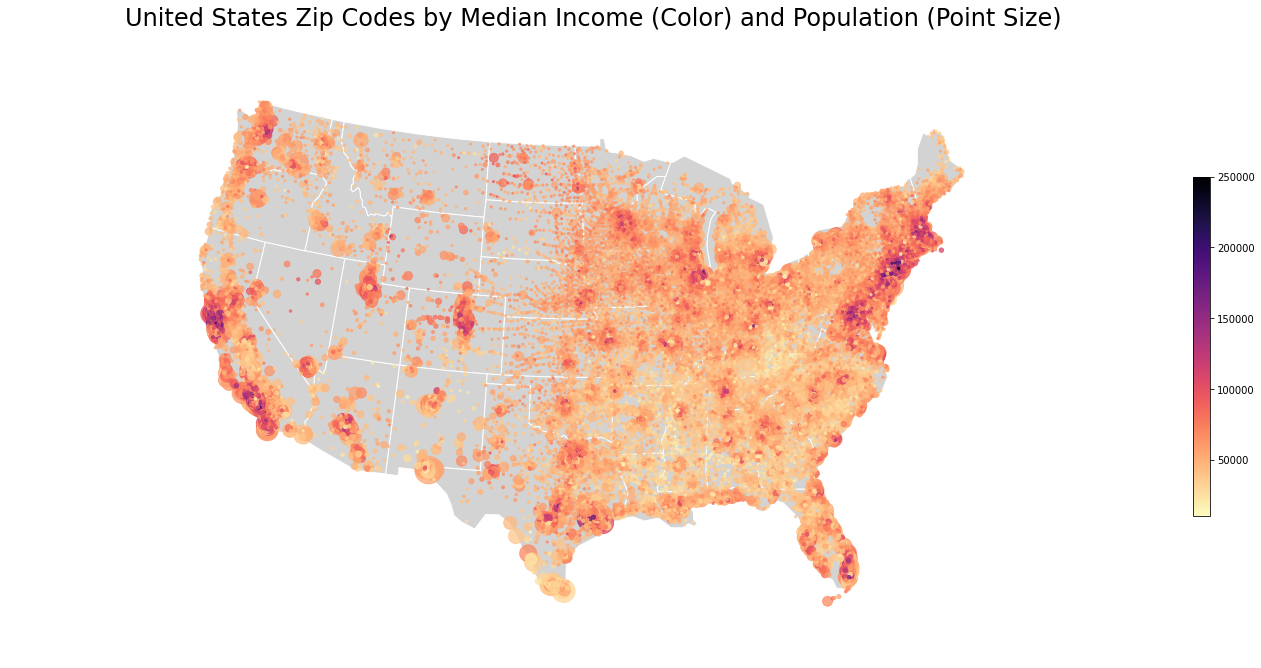

In [174]:
# Load in geo-mapping packages and construct plot.
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc
import geopandas as gpd

contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

scheme = mc.Quantiles(geo_map_subset['Median_household_income'], k=5)
proj = gcrs.AlbersEqualArea()
geo_map_subset = gpd.GeoDataFrame(geo_map_subset,
                                  geometry=gpd.points_from_xy(geo_map_subset.longitude,
                                                              geo_map_subset.latitude))

ax = gplt.polyplot(
    contiguous_usa,
    zorder=-1,
    linewidth=1,
    projection=proj,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(25, 25)
)

gplt.pointplot(
    geo_map_subset,
    scale='Total_population',
    limits=(2, 30),
    hue='Median_household_income',
    cmap='magma_r',
    alpha=.75,
    scheme=None,
    legend=True,
    legend_var='hue',
    legend_kwargs={'shrink':.25, 'pad':0.01},
    ax=ax
)

plt.title("United States Zip Codes by Median Income (Color) and Population (Point Size)", fontsize=24)
#Source: https://residentmario.github.io/geoplot/user_guide/Customizing_Plots.html

## Section 5: Zip Code Arbitrage Case

Using multivariate analysis techniques, our team sought to answer the following question: What are the most under and overrated cities in America? Using median house price as the target variable, we built a number of regression models. Each one used a subset of predictors to estimate this target variable. Our thinking is that zips with abnormally large differences between predicted and observed median house prices indicate "arbitrage" opportunities. If the predicted value is much higher than the actual, that zip is undervalued. If the predicted is lower than the actual, the opposite is true. After testing a number of models, we used our most accurate regression to generate predicted values. We then built our lists of the most over and under rated zips in America - keep scrolling to see the results!

In [23]:
final_df.corr()

,Zip,decommissioned,latitude,longitude,Population_above_25,Percent_pop_less_than_high_school_education,Percent_pop_graduate_or_professional_degree,Percent_pop_high_school_degree_plus,Percent_pop_bachelor_degree_plus,Total_White_Population,...,Percent_of_income_taxed,Tax_burden_percent_of_income,State_and_local_income_tax_burden,State_and_local_sales_tax_burden,Real_estate_tax_burden,Personal_property_tax_burden,Charitable_giving_per_capita,Percent_self_employed,Percent_White,Percent_Minority
Zip,1.000000,NaN,-0.117274,-0.917081,0.066640,0.139439,-0.152405,-0.098536,-0.093037,0.077280,...,-0.071334,-0.129876,-0.154476,0.299815,-0.259106,0.011162,-0.001013,-0.054689,-0.049843,0.049843
decommissioned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.117274,NaN,1.000000,0.023724,-0.223120,-0.265336,0.039172,0.329087,0.061622,-0.187498,...,0.003688,-0.200115,0.195952,-0.362152,0.176128,-0.122782,-0.082983,-0.000939,0.305856,-0.305856
longitude,-0.917081,NaN,0.023724,1.000000,-0.095526,-0.126831,0.088528,0.063079,0.025789,-0.085192,...,0.026093,0.122750,0.039315,-0.263012,0.181246,-0.056039,-0.013791,-0.004538,0.086980,-0.086980
Population_above_25,0.066640,NaN,-0.223120,-0.095526,1.000000,0.118490,0.293867,-0.025564,0.339840,0.912224,...,0.272758,0.334662,0.224581,0.252928,0.267622,0.188894,0.120365,0.272532,-0.401438,0.401438
Percent_pop_less_than_high_school_education,0.139439,NaN,-0.265336,-0.126831,0.118490,1.000000,-0.306017,-0.873587,-0.361183,0.057117,...,-0.333922,-0.090781,-0.211608,0.122168,-0.231701,0.047014,-0.105189,-0.185229,-0.267434,0.267434
Percent_pop_graduate_or_professional_degree,-0.152405,NaN,0.039172,0.088528,0.293867,-0.306017,1.000000,0.473739,0.940772,0.307034,...,0.790464,0.673658,0.589261,0.017021,0.565818,0.046819,0.411967,0.779144,-0.060330,0.060330
Percent_pop_high_school_degree_plus,-0.098536,NaN,0.329087,0.063079,-0.025564,-0.873587,0.473739,1.000000,0.562510,0.045368,...,0.498946,0.166532,0.331389,-0.085358,0.383271,-0.028156,0.167999,0.319884,0.327758,-0.327758
Percent_pop_bachelor_degree_plus,-0.093037,NaN,0.061622,0.025789,0.339840,-0.361183,0.940772,0.562510,1.000000,0.358634,...,0.828868,0.651668,0.594711,0.050061,0.598812,0.071735,0.401118,0.752845,-0.034628,0.034628
Total_White_Population,0.077280,NaN,-0.187498,-0.085192,0.912224,0.057117,0.307034,0.045368,0.358634,1.000000,...,0.317131,0.323759,0.200629,0.263022,0.285281,0.160361,0.129340,0.292211,-0.142330,0.142330


In [24]:
final_df.columns

Index(['Zip', 'type', 'decommissioned', 'primary_city', 'state', 'area_codes',
       'country', 'latitude', 'longitude', 'Population_above_25',
       'Percent_pop_less_than_high_school_education',
       'Percent_pop_graduate_or_professional_degree',
       'Percent_pop_high_school_degree_plus',
       'Percent_pop_bachelor_degree_plus', 'Total_White_Population',
       'Total_housing_units', 'Houses_built_14_or_later',
       'Median_rooms_in_household', 'Tenure_of_owner_occupied_units',
       'Tenure_of_renter_occupied_units', 'Vehicles_per_Household',
       'Median_value_of_owner_units', 'Median_select_monthly_ownership_costs',
       'Median_gross_rent', 'Median_household_income', 'Total_population',
       'Median_age', 'Sex_Ratio_males_per_100_females', 'Number_of_returns',
       'Adjusted_gross_income', 'Total_income_amount', 'Taxable_income_amount',
       'Total_tax_payments_amount', 'Income_tax_amount',
       'Population_19_years_and_under', 'Percent_minors_age_19_and_u

In [25]:
results = smf.ols('Median_value_of_owner_units ~ Percent_of_housing_built_since_2014', data=final_df).fit()

In [26]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     Median_value_of_owner_units   R-squared:                       0.015
Model:                                     OLS   Adj. R-squared:                  0.015
Method:                          Least Squares   F-statistic:                     360.0
Date:                         Thu, 14 May 2020   Prob (F-statistic):           1.06e-79
Time:                                 13:36:55   Log-Likelihood:            -3.2247e+05
No. Observations:                        23918   AIC:                         6.449e+05
Df Residuals:                            23916   BIC:                         6.450e+05
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [27]:
results.rsquared

0.014831196595492258

In [28]:
# Create list with all variables to be tested individually

predictors = ["Percent_pop_less_than_high_school_education", "Percent_pop_bachelor_degree_plus", "Median_gross_rent",
              "Median_household_income", "Median_age", "Sex_Ratio_males_per_100_females", 
              "Median_select_monthly_ownership_costs", "Percent_minors_age_19_and_under", "Percent_seniors_age_65_and_over",
              "Percent_tax_returns_with_gambling_losses", "Percent_tax_returns_with_income_tax_paid", 
              "Percent_of_housing_built_since_2014", "Percent_of_housing_built_before_2000", "Percent_of_income_taxed",
              "Tax_burden_percent_of_income", "State_and_local_income_tax_burden", "State_and_local_sales_tax_burden", 
              "Real_estate_tax_burden", "Personal_property_tax_burden", "Charitable_giving_per_capita", 
              "Percent_self_employed", "Percent_Minority"]
predictors_rsq = {}

In [29]:
# Run simple regressions on median home value for all predictors
# https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html

Y = final_df['Median_value_of_owner_units']

for predictor in predictors:
    X = final_df[predictor]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    predictors_rsq[predictor]=results.rsquared


C:\Users\Philip Schroder\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [30]:
predictors_rsq

{'Percent_pop_less_than_high_school_education': 0.013554903377787086,
 'Percent_pop_bachelor_degree_plus': 0.49191971610092133,
 'Median_gross_rent': 0.6081362020906609,
 'Median_household_income': 0.48802370444419074,
 'Median_age': 0.0001983532965816881,
 'Sex_Ratio_males_per_100_females': 0.0035182762486544172,
 'Median_select_monthly_ownership_costs': 0.47499748292414856,
 'Percent_minors_age_19_and_under': 0.01871691003981868,
 'Percent_seniors_age_65_and_over': 0.001348532779435141,
 'Percent_tax_returns_with_gambling_losses': 0.07911689599350713,
 'Percent_tax_returns_with_income_tax_paid': 0.22265842949225123,
 'Percent_of_housing_built_since_2014': 0.014831196595492258,
 'Percent_of_housing_built_before_2000': 0.0060392443901085,
 'Percent_of_income_taxed': 0.483410221958097,
 'Tax_burden_percent_of_income': 0.3580425476385346,
 'State_and_local_income_tax_burden': 0.48102397098437766,
 'State_and_local_sales_tax_burden': 0.001597132307342708,
 'Real_estate_tax_burden': 0.2623

In [31]:
# Print predictors from highest to lowest R-squared
OrderedDict(sorted(predictors_rsq.items(), key=lambda t:t[1], reverse=True))

OrderedDict([('Median_gross_rent', 0.6081362020906609),
             ('Percent_self_employed', 0.5468526221052508),
             ('Percent_pop_bachelor_degree_plus', 0.49191971610092133),
             ('Median_household_income', 0.48802370444419074),
             ('Percent_of_income_taxed', 0.483410221958097),
             ('State_and_local_income_tax_burden', 0.48102397098437766),
             ('Median_select_monthly_ownership_costs', 0.47499748292414856),
             ('Tax_burden_percent_of_income', 0.3580425476385346),
             ('Real_estate_tax_burden', 0.2623367725331448),
             ('Percent_tax_returns_with_income_tax_paid', 0.22265842949225123),
             ('Charitable_giving_per_capita', 0.18140791321064875),
             ('Percent_tax_returns_with_gambling_losses', 0.07911689599350713),
             ('Percent_minors_age_19_and_under', 0.01871691003981868),
             ('Percent_Minority', 0.015566001245105099),
             ('Percent_of_housing_built_since_2014', 0

#### Model 1: Use all predictors with R^2 over 10% (11 predictors)

In [32]:
# Regression with all predictors that have R-squared greater than 10%
results_11 = smf.ols('Median_value_of_owner_units ~ Median_gross_rent + Percent_self_employed + Percent_pop_bachelor_degree_plus + Median_household_income + Percent_of_income_taxed + State_and_local_income_tax_burden + Median_select_monthly_ownership_costs + Tax_burden_percent_of_income + Real_estate_tax_burden + Percent_tax_returns_with_income_tax_paid + Charitable_giving_per_capita', data=final_df).fit()

In [33]:
results_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Median_value_of_owner_units   R-squared:                       0.777
Model:                                     OLS   Adj. R-squared:                  0.777
Method:                          Least Squares   F-statistic:                     7586.
Date:                         Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                                 13:36:56   Log-Likelihood:            -3.0468e+05
No. Observations:                        23918   AIC:                         6.094e+05
Df Residuals:                            23906   BIC:                         6.095e+05
Df Model:                                   11                                         
Covariance Type:                     nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -5.154e+04   9028.420     -5.709      0.000   -6.92e+04   -3.38e+04
Median_gross_rent                          204.6860      2.397     85.375      0.000     199.987     209.385
Percent_self_employed                       5.1e+06   1.34e+05     37.994      0.000    4.84e+06    5.36e+06
Percent_pop_bachelor_degree_plus          -174.4813     71.498     -2.440      0.015    -314.622     -34.340
Median_household_income                      0.1484      0.049      3.025      0.002       0.052       0.244
Percent_of_income_taxed                   8.889e+05   5.14e+04     17.295      0.000    7.88e+05     9.9e+05
State_and_local_income_tax_burden          3.01e+06   4.64e+04     64.930      0.000    2.92e+06     3.1e+06
Median_select_monthly_ownership_costs      151.2438      5.323     28.411      0.000     140.810     161.678
Tax_burden_percent_of_income              -5.66e+05    4.6e+04    -12.296      0.000   -6.56e+05   -4.76e+05
Real_estate_tax_burden                   -3.116e+06   9.04e+04    -34.481      0.000   -3.29e+06   -2.94e+06
Percent_tax_returns_with_income_tax_paid -9.409e+04   1.23e+04     -7.648      0.000   -1.18e+05      -7e+04
Charitable_giving_per_capita              2307.1973    250.803      9.199      0.000    1815.608    2798.786
==============================================================================
Omnibus:                    15978.025   Durbin-Watson:                   1.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           701184.158
Skew:                           2.650   Prob(JB):                         0.00
Kurtosis:                      28.990   Cond. No.                     1.65e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
final_df['yhat_11'] = results_11.predict()
final_df['error_11'] = final_df['Median_value_of_owner_units'] - final_df['yhat_11']

#### Model 2: Use top 5 predictors based on R^2 (>48.3%)

In [35]:
# Regression with top 5 predictors based on R-squared

results_5 = smf.ols('Median_value_of_owner_units ~ Median_gross_rent + Percent_self_employed + Percent_pop_bachelor_degree_plus + Median_household_income + Percent_of_income_taxed', data=final_df).fit()

In [36]:
results_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Median_value_of_owner_units   R-squared:                       0.728
Model:                                     OLS   Adj. R-squared:                  0.728
Method:                          Least Squares   F-statistic:                 1.280e+04
Date:                         Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                                 13:36:56   Log-Likelihood:            -3.0708e+05
No. Observations:                        23918   AIC:                         6.142e+05
Df Residuals:                            23912   BIC:                         6.142e+05
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -1.094e+05   2988.198    -36.606      0.000   -1.15e+05   -1.04e+05
Median_gross_rent                  224.5041      2.467     90.999      0.000     219.668     229.340
Percent_self_employed             7.789e+06   1.27e+05     61.095      0.000    7.54e+06    8.04e+06
Percent_pop_bachelor_degree_plus   105.9936     77.359      1.370      0.171     -45.634     257.622
Median_household_income              0.3059      0.045      6.823      0.000       0.218       0.394
Percent_of_income_taxed           5.733e+05   3.57e+04     16.059      0.000    5.03e+05    6.43e+05
==============================================================================
Omnibus:                    18814.712   Durbin-Watson:                   0.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1027827.587
Skew:                           3.344   Prob(JB):                         0.00
Kurtosis:                      34.410   Cond. No.                     1.38e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
final_df['yhat_5'] = results_5.predict()
final_df['error_5'] = final_df['Median_value_of_owner_units'] - final_df['yhat_5']

#### Model 3: Use top 2 predictors based on R^2 (>50%)

In [38]:
# Regression with top 2 predictors based on R-squared

results_2 = smf.ols('Median_value_of_owner_units ~ Median_gross_rent + Percent_self_employed', data=final_df).fit()

In [39]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Median_value_of_owner_units   R-squared:                       0.721
Model:                                     OLS   Adj. R-squared:                  0.721
Method:                          Least Squares   F-statistic:                 3.094e+04
Date:                         Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                                 13:36:56   Log-Likelihood:            -3.0737e+05
No. Observations:                        23918   AIC:                         6.147e+05
Df Residuals:                            23915   BIC:                         6.148e+05
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -5.658e+04   1776.155    -31.855      0.000   -6.01e+04   -5.31e+04
Median_gross_rent       249.6999      2.041    122.324      0.000     245.699     253.701
Percent_self_employed  9.668e+06   9.81e+04     98.516      0.000    9.48e+06    9.86e+06
==============================================================================
Omnibus:                    18002.916   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           886048.967
Skew:                           3.152   Prob(JB):                         0.00
Kurtosis:                      32.144   Cond. No.                     1.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
final_df['yhat_2'] = results_2.predict()
final_df['error_2'] = final_df['Median_value_of_owner_units'] - final_df['yhat_2']

#### Model 4: Using AICc to get best 3 predictor model (Median Gross Rent, Percent Self Employed, State and Local Income Tax Burden
This was calculated in R using the glmulti package, limiting to the lowest AICc model out of the 11 previously identified predictors.

In [41]:
# Regression with top 3 predictors based on AICc

results_aicc_3 = smf.ols('Median_value_of_owner_units ~ Median_gross_rent + Percent_self_employed + State_and_local_income_tax_burden', data=final_df).fit()

In [42]:
results_aicc_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Median_value_of_owner_units   R-squared:                       0.760
Model:                                     OLS   Adj. R-squared:                  0.760
Method:                          Least Squares   F-statistic:                 2.520e+04
Date:                         Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                                 13:36:56   Log-Likelihood:            -3.0559e+05
No. Observations:                        23918   AIC:                         6.112e+05
Df Residuals:                            23914   BIC:                         6.112e+05
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -6.865e+04   1660.786    -41.339      0.000   -7.19e+04   -6.54e+04
Median_gross_rent                   209.3143      2.005    104.404      0.000     205.385     213.244
Percent_self_employed              7.414e+06   9.81e+04     75.534      0.000    7.22e+06    7.61e+06
State_and_local_income_tax_burden  2.783e+06    4.5e+04     61.827      0.000     2.7e+06    2.87e+06
==============================================================================
Omnibus:                    17024.479   Durbin-Watson:                   1.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           770594.874
Skew:                           2.914   Prob(JB):                         0.00
Kurtosis:                      30.190   Cond. No.                     1.75e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
final_df['yhat_aicc_3'] = results_aicc_3.predict()
final_df['error_aicc_3'] = final_df['Median_value_of_owner_units'] - final_df['yhat_aicc_3']

#### Model 5: Using AICc to get best 4 predictor model (Median Gross Rent, Percent Self Employed, State and Local Income Tax Burden, State and Local Sales Tax Burden
This was calculated in R using the glmulti package, limiting to the lowest AICc model out of the 11 previously identified predictors.

In [45]:
# Regression with top 3 predictors based on AICc

results_aicc_4 = smf.ols('Median_value_of_owner_units ~ Median_gross_rent + Percent_self_employed + State_and_local_income_tax_burden + State_and_local_sales_tax_burden', data=final_df).fit()

In [46]:
results_aicc_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Median_value_of_owner_units   R-squared:                       0.767
Model:                                     OLS   Adj. R-squared:                  0.767
Method:                          Least Squares   F-statistic:                 1.969e+04
Date:                         Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                                 13:39:10   Log-Likelihood:            -3.0522e+05
No. Observations:                        23918   AIC:                         6.105e+05
Df Residuals:                            23913   BIC:                         6.105e+05
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -7.384e+04   1645.900    -44.861      0.000   -7.71e+04   -7.06e+04
Median_gross_rent                   183.4833      2.185     83.956      0.000     179.200     187.767
Percent_self_employed              7.032e+06   9.76e+04     72.030      0.000    6.84e+06    7.22e+06
State_and_local_income_tax_burden  3.688e+06   5.52e+04     66.842      0.000    3.58e+06     3.8e+06
State_and_local_sales_tax_burden    9.48e+06   3.44e+05     27.533      0.000    8.81e+06    1.02e+07
==============================================================================
Omnibus:                    17110.598   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           777762.111
Skew:                           2.936   Prob(JB):                         0.00
Kurtosis:                      30.312   Cond. No.                     6.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
final_df['yhat_aicc_4'] = results_aicc_4.predict()
final_df['error_aicc_4'] = final_df['Median_value_of_owner_units'] - final_df['yhat_aicc_4']

#### Compare model errors to choose best model

-8.215150561547218e-09


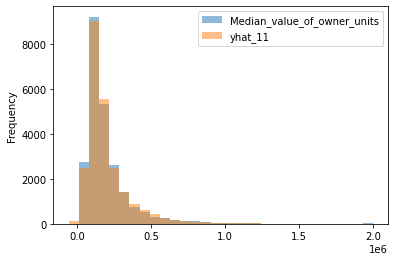

In [48]:
print(final_df['error_11'].mean())
final_df[['Median_value_of_owner_units','yhat_11']].plot.hist(bins=30,alpha=.5)

2.9863501515870897e-09


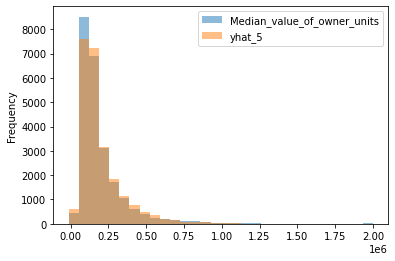

In [49]:
print(final_df['error_5'].mean())
final_df[['Median_value_of_owner_units','yhat_5']].plot.hist(bins=30,alpha=.5)

-4.517056124390931e-10


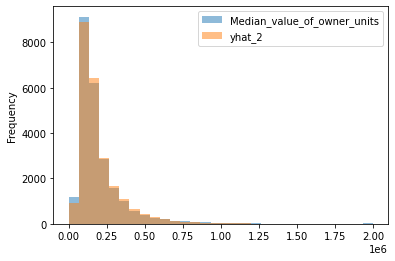

In [50]:
print(final_df['error_2'].mean())
final_df[['Median_value_of_owner_units','yhat_2']].plot.hist(bins=30,alpha=.5)

-1.8074113892137292e-10


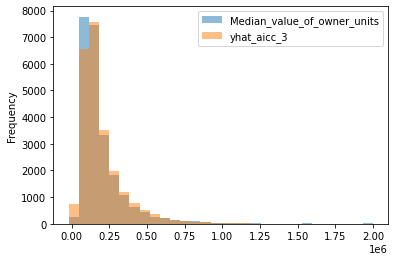

In [51]:
print(final_df['error_aicc_3'].mean())
final_df[['Median_value_of_owner_units','yhat_aicc_3']].plot.hist(bins=30,alpha=.5)

6.003755908196203e-09


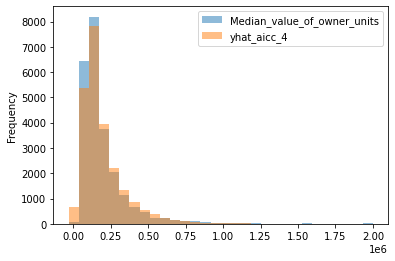

In [52]:
print(final_df['error_aicc_4'].mean())
final_df[['Median_value_of_owner_units','yhat_aicc_4']].plot.hist(bins=30,alpha=.5)

Since the AICc 3 variable model's mean error is the tied with the AICc 4 variable model, but has fewer predictors, we will choose it for our multiple regression model.

In [53]:
final_df[['Median_gross_rent', 'Percent_self_employed', 'State_and_local_income_tax_burden']].corr()

,Median_gross_rent,Percent_self_employed,State_and_local_income_tax_burden
Median_gross_rent,1.000000,0.604806,0.564507
Percent_self_employed,0.604806,1.000000,0.585619
State_and_local_income_tax_burden,0.564507,0.585619,1.000000


There is some collinearity, but not an overwhelming amount. They are still relatively independent variables, so we will keep all three. However, median_gross_rent picks up over half of the linear impact of both percent_self_employed income tax returns and state_and_local_income_tax_burden on median house price. It may be that there is some correlation between how expensive housing is and the state/local tax burden and how many people are self-employed.

#### Which 10 cities are the cheapest and the most expensive relative to the prediction?
We could have an arbitrage situation where a person could get a better or worse house than predicted by the selected model. Before continuing our analysis we needed to build a subset of our data with housing prices slightly under 2,000,000. This price was the cap in our data set.

In [72]:
# create a subset that removes zips with median home value at upper limit as this distorts output
final_df_subset1=final_df.loc[final_df['Median_value_of_owner_units']<2000000,:]

In [73]:
final_df_subset1[['Zip','primary_city','state','Median_value_of_owner_units','Median_gross_rent','Percent_self_employed','State_and_local_income_tax_burden','yhat_aicc_3','error_aicc_3']].sort_values(by=['error_aicc_3'],ascending=False)[0:10]

,Zip,primary_city,state,Median_value_of_owner_units,Median_gross_rent,Percent_self_employed,State_and_local_income_tax_burden,yhat_aicc_3,error_aicc_3
39333,93920,Big Sur,CA,1536500,702,0.000000,0.021608,1.384255e+05,1.398074e+06
3804,11024,Great Neck,NY,1644500,1794,0.025157,0.088488,7.396452e+05,9.048548e+05
39371,94025,Menlo Park,CA,1950600,2268,0.052156,0.105789,1.087170e+06,8.634296e+05
38123,91008,Duarte,CA,1606100,2777,0.000000,0.092937,7.712792e+05,8.348208e+05
3017,8247,Stone Harbor,NJ,1146600,1325,0.000000,0.050704,3.498096e+05,7.967904e+05
39380,94040,Mountain View,CA,1618800,2317,0.025626,0.080307,8.298185e+05,7.889815e+05
39710,94946,Nicasio,CA,1338200,1875,0.000000,0.081217,5.498570e+05,7.883430e+05
37972,90266,Manhattan Beach,CA,1947900,2499,0.057793,0.100690,1.163119e+06,7.847805e+05
39398,94087,Sunnyvale,CA,1530200,2333,0.020898,0.072900,7.775009e+05,7.526991e+05
2457,6830,Greenwich,CT,1552800,1800,0.042449,0.072958,8.258678e+05,7.269322e+05


California dominates the list of "overrated" cities. The top 10 cities with predicted values lower than the actual counterparts are entirely coastal. Unsurprisingly all of these zip codes are in remarkably expensive areas. Mountain View and Menlo Park serve as the headquarters for Google and Facebook respectively. This could be driving up housing properties in these towns. Stone Harbor, Big Sur, and Manhattan Beach are known for tourism and housing values might be driven up by wealthy vacation home buyers. Finally, Great Neck and Greenwich are popular neighborhoods for New York City's finaciers - a likely reason their values are distorted.

In [55]:
final_df[['Zip','primary_city','state','Median_value_of_owner_units','Median_gross_rent','Percent_self_employed','State_and_local_income_tax_burden','yhat_aicc_3','error_aicc_3']].sort_values(by=['error_aicc_3'],ascending=True)[0:10]

,Zip,primary_city,state,Median_value_of_owner_units,Median_gross_rent,Percent_self_employed,State_and_local_income_tax_burden,yhat_aicc_3,error_aicc_3
39826,95134,San Jose,CA,170300,2793,0.002163,0.058015,6.934661e+05,-523166.054120
2139,6092,West Simsbury,CT,372600,2350,0.035354,0.060731,8.543581e+05,-481758.079607
8428,20759,Fulton,MD,678000,3500,0.038328,0.074122,1.154389e+06,-476389.010773
28138,64113,Kansas City,MO,376500,2066,0.043771,0.057167,8.473953e+05,-470895.307525
35639,81654,Snowmass,CO,287300,3367,0.000000,0.036937,7.389111e+05,-451611.128443
3430,10001,New York,NY,343400,2065,0.020209,0.097442,7.846032e+05,-441203.214460
5398,14534,Pittsford,NY,257800,1605,0.037874,0.053132,6.959553e+05,-438155.347180
28906,66206,Leawood,KS,410200,2041,0.049116,0.044466,8.464375e+05,-436237.463714
3671,10546,Millwood,NY,688700,3278,0.042857,0.062343,1.108717e+06,-420017.189630
39400,94089,Sunnyvale,CA,273500,2700,0.005119,0.055163,6.879804e+05,-414480.442357


The 10 cities with the lowest median house price relative to the prediction are more geographically spread out across the United States. Interestingly, the biggest difference in prediction is in San Jose, CA, just south of the San Francisco metropolitan area (and combined in a single Combined Statistical Area). Sunnyvale, CA is also part of the San Francisco metropolitan area, so its inclusion here is also a bit puzzling. Interestingly, these are all very high median rent locations (similar to the top list shown previously) with very low median house prices relative to the previous list, which may be resulting in very low median house values. This may represent a buying opportunity for potential homeowners.

## Section 6: Sister Cities Case

SciKit Learn's package helped our team build an unsupervised machine learning model. We used the model to conduct a clustering analysis on our data to see if we could statistically prove the existance of sister cities.

For this analysis, we will create 10 clusters the zip codes using the K-means algorithm from scikit-learn on the top 20 metrics identified in the median house price prediction analysis. These clusters will be differentiated into samples of equal variance based on within-cluster sum-of-squares. This can help us identify sister zip codes in the data.

After clustering our data, we will plot these clusters to visually see their characteristics. We will also plot them on a map to see how geography plays a role in clustering. Fianlly we will generate a table listing key characteristics for each cluster and use our analysis to name each cluster based on it's "ideal" resident. 

In [56]:
#Use top 20 predictors + median house value

predictors_top_21 = ['Median_value_of_owner_units', 
                     'Median_gross_rent', 'Percent_self_employed', 'Percent_pop_bachelor_degree_plus', 
                     'Median_household_income', 'Percent_of_income_taxed', 'State_and_local_income_tax_burden', 
                     'Median_select_monthly_ownership_costs', 'Tax_burden_percent_of_income', 
                     'Real_estate_tax_burden', 'Percent_tax_returns_with_income_tax_paid', 'Charitable_giving_per_capita', 
                     'Percent_tax_returns_with_gambling_losses', 'Percent_minors_age_19_and_under', 
                     'Percent_Minority', 'Percent_of_housing_built_since_2014', 
                     'Percent_pop_less_than_high_school_education', 'Personal_property_tax_burden', 
                     'Percent_of_housing_built_before_2000', 'Sex_Ratio_males_per_100_females', 
                     'State_and_local_sales_tax_burden']

First, we built scatterplots to visualize the clusters by a select set of attributes. We are particularly interested in the more unique attributes of these clusters. More on that below.

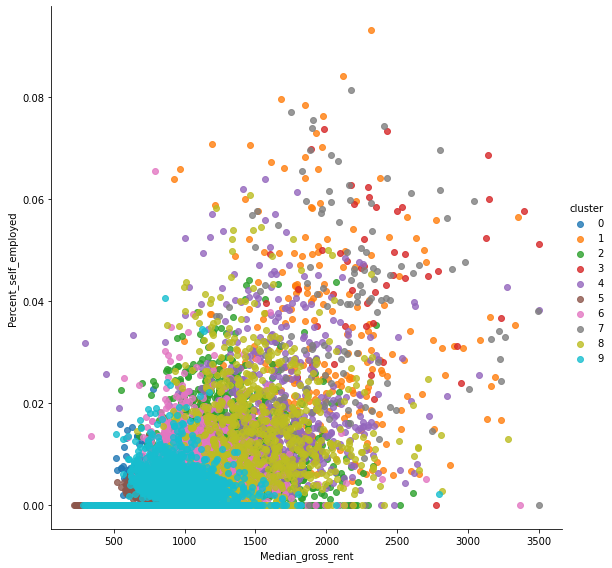

In [59]:
kmeans = KMeans(n_clusters=10, random_state=42)
predictors_for_graph = ['Median_gross_rent', 'Percent_self_employed']
final_df['cluster'] = kmeans.fit_predict(final_df[predictors_top_21]).astype(int)
sns.lmplot(predictors_for_graph[0], predictors_for_graph[1], data=final_df, hue='cluster', fit_reg=False, height=8)
plt.show()

The chart above shows that there is a vague correlation between rent and self employement status. This suggests that homes double of offices for many self employed individuals.

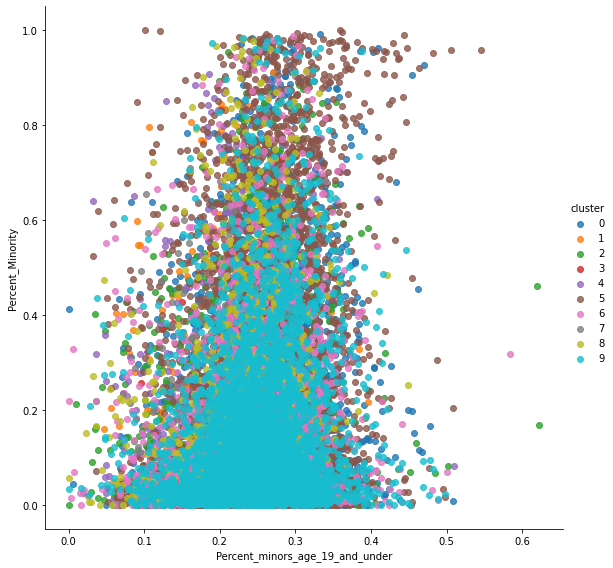

In [224]:
kmeans = KMeans(n_clusters=10, random_state=42)
predictors_for_graph = ['Percent_minors_age_19_and_under', 'Percent_Minority']
final_df['cluster'] = kmeans.fit_predict(final_df[predictors_top_21]).astype(int)
sns.lmplot(predictors_for_graph[0], predictors_for_graph[1], data=final_df, hue='cluster', fit_reg=False, height=8)
plt.show()

There is research evidence that minorities have more children compared to their non-hispanic white counterparts. This chart suggests that is the case. Although not to a staggering degree. 

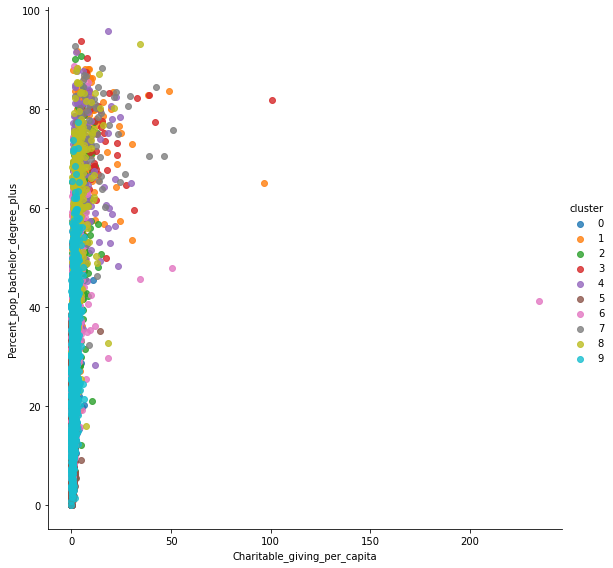

In [225]:
kmeans = KMeans(n_clusters=10, random_state=42)
predictors_for_graph = ['Charitable_giving_per_capita', 'Percent_pop_bachelor_degree_plus']
final_df['cluster'] = kmeans.fit_predict(final_df[predictors_top_21]).astype(int)
sns.lmplot(predictors_for_graph[0], predictors_for_graph[1], data=final_df, hue='cluster', fit_reg=False, height=8)
plt.show()

Generally, Americans give very little to charity. That being said, the highly educated tend to give a little more than everyone else. Based on our clustering, groups 1 and 3 are highly educated, wealthy, and the most charitable of the pack.

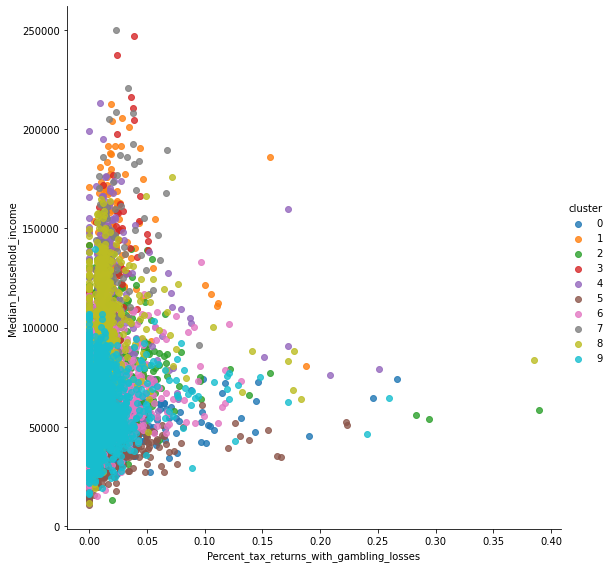

In [226]:
kmeans = KMeans(n_clusters=10, random_state=42)
predictors_for_graph = ['Percent_tax_returns_with_gambling_losses', 'Median_household_income']
final_df['cluster'] = kmeans.fit_predict(final_df[predictors_top_21]).astype(int)
sns.lmplot(predictors_for_graph[0], predictors_for_graph[1], data=final_df, hue='cluster', fit_reg=False, height=8)
plt.show()

Gambling losses point out an interesting trend. The heaviest of these losses are sustained by middle income households. The ultra rich and ultra poor have signifcantly less losses related to gambling in their tax filings.

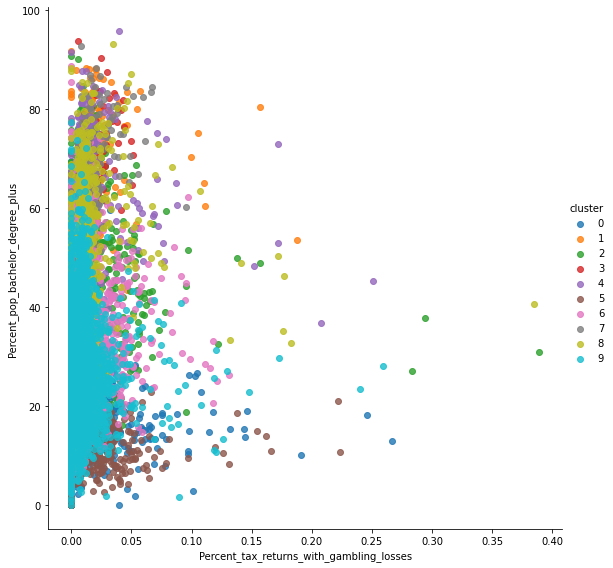

In [227]:
kmeans = KMeans(n_clusters=10, random_state=42)
predictors_for_graph = ['Percent_tax_returns_with_gambling_losses', 'Percent_pop_bachelor_degree_plus']
final_df['cluster'] = kmeans.fit_predict(final_df[predictors_top_21]).astype(int)
sns.lmplot(predictors_for_graph[0], predictors_for_graph[1], data=final_df, hue='cluster', fit_reg=False, height=8)
plt.show()

Although the income of high risk gamblers was relatively normal, the heaviest losses usually occur in lesser educated clusters.

After visualizing the clusters, we built out dataframes to get a feel for the characteristics of each group. These dataframes will also be used in our final analysis.

In [64]:
centroids = final_df[final_df.columns.difference(['Zip', 'decommissioned', 'latitude', 'longitude'])].groupby('cluster').mean()
centroids

,Adjusted_gross_income,Charitable_giving_per_capita,Houses_built_14_or_later,Houses_built_before_2000,Income_tax_amount,Median_age,Median_gross_rent,Median_household_income,Median_rooms_in_household,Median_select_monthly_ownership_costs,...,error_11,error_2,error_5,error_aicc_3,error_aicc_4,yhat_11,yhat_2,yhat_5,yhat_aicc_3,yhat_aicc_4
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.089136e+05,0.700712,45.722250,3617.583041,20904.734602,41.685445,735.470205,51000.999833,0.315690,417.312636,...,-7839.892328,-8500.029675,-7535.116725,-6565.281254,-5736.752408,1.310555e+05,131715.619727,130750.706776,1.297809e+05,1.289523e+05
1,1.932010e+06,4.841244,177.408669,9456.204334,374955.526316,41.637771,1888.077399,110708.513932,0.234675,959.554180,...,126203.644275,157951.258049,165078.948611,142402.993666,145470.898512,7.024078e+05,670660.197060,663532.506498,6.862085e+05,6.831406e+05
2,9.343490e+05,1.954473,191.226404,6993.517082,139193.380428,41.849855,1283.397221,82165.112334,0.265895,708.160394,...,-5295.597682,672.609352,-7106.344535,-6605.323877,-10359.323847,3.475181e+05,341549.857353,349328.811240,3.488278e+05,3.525818e+05
3,3.983255e+06,14.447182,95.920000,8789.140000,903129.040000,43.712000,2356.520000,140529.800000,0.256000,1186.000000,...,724249.114994,850537.120417,871038.311592,775914.222892,764797.020349,1.088739e+06,962450.879583,941949.688408,1.037074e+06,1.048191e+06
4,1.450842e+06,3.127870,177.200737,9311.740331,251345.946593,41.566667,1651.104972,97495.476980,0.229098,891.856354,...,74534.966769,91926.238390,92419.440673,86005.301603,88436.490668,5.459370e+05,528545.768976,528052.566693,5.344667e+05,5.320355e+05
5,1.003665e+05,0.496205,21.837570,2543.308848,8571.398646,41.751420,649.539782,41840.626775,0.327633,367.757016,...,-17296.271556,-27498.057633,-19521.646098,-16743.404106,-11950.356948,9.617227e+04,106374.056313,98397.644777,9.561940e+04,9.082636e+04
6,6.123814e+05,1.478971,161.478851,5463.709912,81752.647096,42.053125,1057.938447,70148.207702,0.286995,579.722854,...,426.935365,2167.437610,-5411.725441,-4762.954442,-9445.538947,2.472925e+05,245552.038400,253131.201451,2.524824e+05,2.571650e+05
7,2.818923e+06,7.325526,127.542254,10477.478873,601985.866197,42.830986,2086.316901,125083.887324,0.232394,1030.704225,...,281271.910563,340543.212786,353240.418833,305903.236675,305024.859064,8.666577e+05,807386.364679,794689.158631,8.420263e+05,8.429047e+05
8,1.140392e+06,2.280238,167.101842,7963.462622,180575.937161,41.711268,1488.231853,91591.644637,0.248971,820.836403,...,16862.611433,23880.762211,20506.392536,20112.465824,20455.984846,4.438098e+05,436791.610486,440165.980161,4.405599e+05,4.402164e+05


In [65]:
centroids = final_df[['Zip','Median_value_of_owner_units', 
                     'Median_gross_rent', 'Percent_self_employed', 'Percent_pop_bachelor_degree_plus', 
                     'Median_household_income', 'Percent_of_income_taxed', 'State_and_local_income_tax_burden', 
                     'Median_select_monthly_ownership_costs', 'Tax_burden_percent_of_income', 
                     'Real_estate_tax_burden', 'Percent_tax_returns_with_income_tax_paid', 'Charitable_giving_per_capita', 
                     'Percent_tax_returns_with_gambling_losses', 'Percent_minors_age_19_and_under', 
                     'Percent_Minority', 'Percent_of_housing_built_since_2014', 
                     'Percent_pop_less_than_high_school_education', 'Personal_property_tax_burden', 
                     'Percent_of_housing_built_before_2000', 'Sex_Ratio_males_per_100_females', 
                     'State_and_local_sales_tax_burden','cluster']].groupby('cluster').median()
centroids

,Zip,Median_value_of_owner_units,Median_gross_rent,Percent_self_employed,Percent_pop_bachelor_degree_plus,Median_household_income,Percent_of_income_taxed,State_and_local_income_tax_burden,Median_select_monthly_ownership_costs,Tax_burden_percent_of_income,...,Charitable_giving_per_capita,Percent_tax_returns_with_gambling_losses,Percent_minors_age_19_and_under,Percent_Minority,Percent_of_housing_built_since_2014,Percent_pop_less_than_high_school_education,Personal_property_tax_burden,Percent_of_housing_built_before_2000,Sex_Ratio_males_per_100_females,State_and_local_sales_tax_burden
cluster,,,,,,,,,,,,,,,,,,,,,
0,48875.0,121900.0,719.0,0.000000,17.50,50972.0,0.092428,0.015565,411.0,0.131776,...,0.626027,0.000000,0.248584,0.063145,0.005656,3.60,0.000561,0.861798,98.5,0.000428
1,90503.0,813200.0,1844.0,0.022453,58.70,105433.0,0.175039,0.059527,881.0,0.191174,...,2.939299,0.012291,0.223220,0.243412,0.007390,2.20,0.000771,0.898566,95.8,0.000543
2,33931.0,340300.0,1261.0,0.006757,41.80,81806.0,0.135129,0.034413,663.0,0.156250,...,1.496478,0.009275,0.239450,0.143291,0.010466,2.10,0.000771,0.837667,96.9,0.000575
3,92654.0,1975300.0,2310.5,0.045549,72.35,139681.0,0.220192,0.104927,1187.5,0.254448,...,10.566039,0.025637,0.225836,0.196968,0.008451,1.15,0.000453,0.908538,93.6,0.000229
4,81611.0,614800.0,1627.0,0.015296,51.60,94777.0,0.157490,0.046968,804.0,0.175883,...,1.967577,0.011364,0.228374,0.233014,0.007598,2.60,0.000870,0.896413,97.1,0.000717
5,51033.5,81700.0,641.5,0.000000,13.40,41321.5,0.081586,0.010597,366.0,0.131813,...,0.443870,0.000000,0.250231,0.083076,0.002891,4.80,0.000415,0.894685,98.2,0.000129
6,48271.5,244900.0,1041.5,0.001508,32.60,69693.5,0.118417,0.027887,556.0,0.143888,...,1.135357,0.006763,0.237844,0.106272,0.010716,2.20,0.000743,0.807762,97.6,0.000536
7,92056.0,1108900.0,2084.0,0.033154,67.10,123775.5,0.199046,0.078569,961.0,0.219616,...,4.030262,0.014226,0.202182,0.232680,0.006548,1.40,0.000616,0.924630,94.7,0.000375
8,33449.0,457200.0,1450.0,0.010824,48.80,91605.0,0.147624,0.039712,767.0,0.165434,...,1.684767,0.011053,0.237273,0.190204,0.008479,2.20,0.000883,0.877632,96.3,0.000704


In [66]:
cluster_count = {}

clusters = sorted(final_df.cluster.unique())
for cluster in clusters:
    counts = final_df[final_df.cluster == cluster].shape[0]
    cluster_count[cluster] = counts
    #data["count"].append(counts)
    #cluster_count.append(counts)
cluster_count_df = pd.DataFrame.from_dict(cluster_count, orient='index').rename(columns={0: "cluster_count"})
cluster_count_df['cluster'] = range(0,10)

cluster_count_df

,cluster_count,cluster
0,5991,0
1,323,1
2,1727,2
3,50,3
4,543,4
5,6058,5
6,3168,6
7,142,7
8,923,8
9,4993,9


Next we plotted the clusters on a map to see if there are any geographic trends at play.

In [182]:
geo_map_clusters = final_df[['Zip', 'state', 'longitude', 'latitude', 'Median_value_of_owner_units', 
                     'Median_gross_rent', 'Percent_self_employed', 'Percent_pop_bachelor_degree_plus', 
                     'Median_household_income', 'Percent_of_income_taxed', 'State_and_local_income_tax_burden', 
                     'Median_select_monthly_ownership_costs', 'Tax_burden_percent_of_income', 
                     'Real_estate_tax_burden', 'Percent_tax_returns_with_income_tax_paid', 'Charitable_giving_per_capita', 
                     'Percent_tax_returns_with_gambling_losses', 'Percent_minors_age_19_and_under', 
                     'Percent_Minority', 'Percent_of_housing_built_since_2014', 
                     'Percent_pop_less_than_high_school_education', 'Personal_property_tax_burden', 
                     'Percent_of_housing_built_before_2000', 'Total_population', 'Sex_Ratio_males_per_100_females', 
                     'State_and_local_sales_tax_burden','cluster']]

In [183]:
# Remove non-conus states to make geo-mapping easier.
geo_map_clusters=geo_map_clusters.loc[geo_map_clusters['state']!="HI"]
geo_map_clusters=geo_map_clusters.loc[geo_map_clusters['state']!="AK"]

Text(0.5, 1.0, 'United States Zip Codes by Cluster')

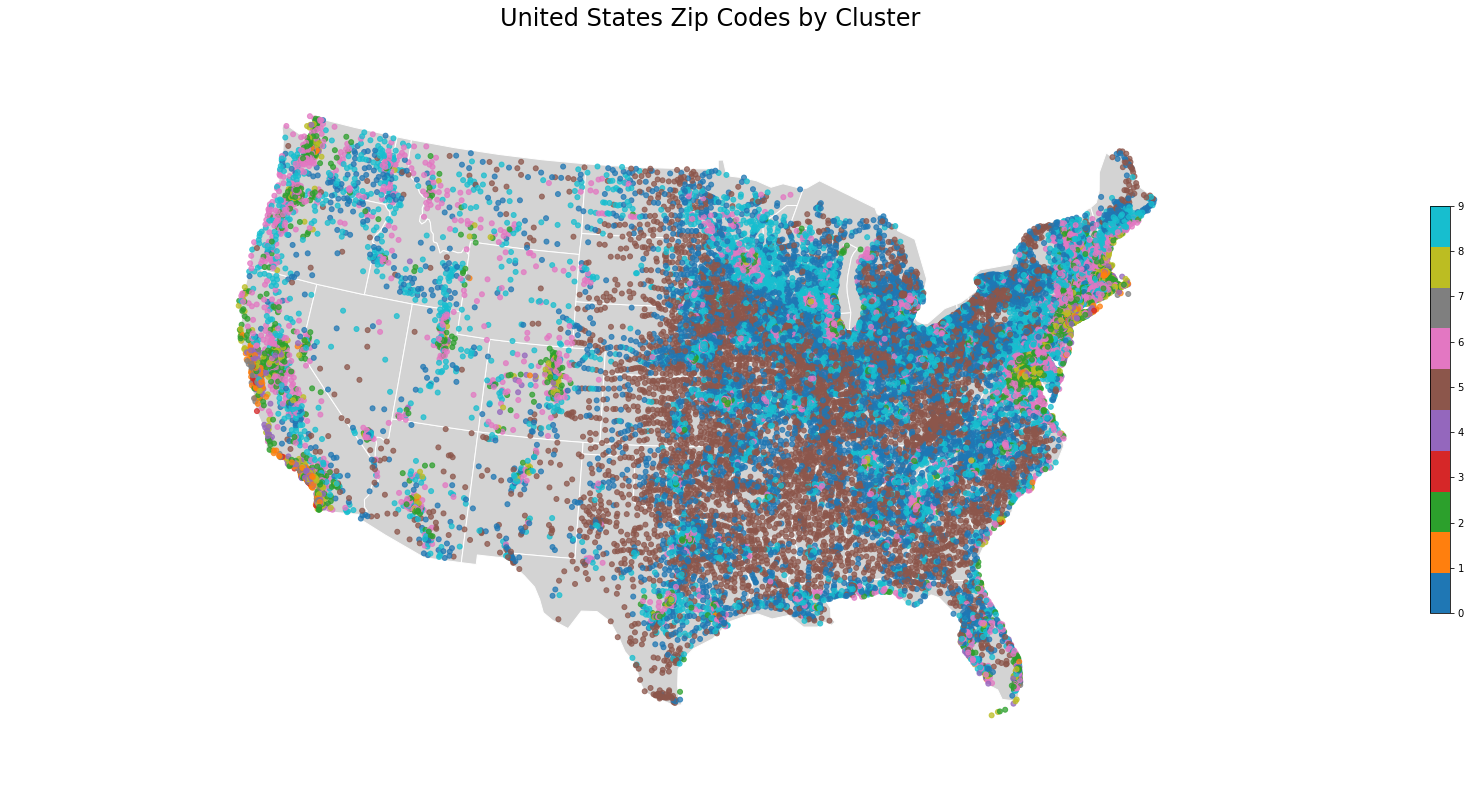

In [200]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

scheme = mc.Quantiles(geo_map_subset['Median_household_income'], k=5)
proj = gcrs.AlbersEqualArea()
geo_map_clusters = gpd.GeoDataFrame(geo_map_clusters,
                                  geometry=gpd.points_from_xy(geo_map_clusters.longitude,
                                                              geo_map_clusters.latitude))

ax = gplt.polyplot(
    contiguous_usa,
    zorder=-1,
    linewidth=1,
    projection=proj,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(30, 30)
)

gplt.pointplot(
    geo_map_clusters,
    hue='cluster',
    cmap='tab10',
    alpha=.75,
    legend=True,
    scheme=None,
    legend_kwargs={'shrink':.25, 'pad':0.01},
    ax=ax
)

plt.title("United States Zip Codes by Cluster", fontsize=24)
#Source: https://residentmario.github.io/geoplot/user_guide/Customizing_Plots.html

To solidify the analysis we built a summary table that displays the key statistics for each cluster. We then re-named the clusters based on observed characteristics. Median Income and house value drives a lot of the clustering so these themes factor prominently in our names.

In [217]:
cluster_table=centroids.merge(cluster_count_df, on='cluster', how='left').drop(columns=['cluster','Zip']).transpose()

In [212]:
#cluster_table.to_csv('C:/Users/Philip Schroder/Desktop/NYU MBA 2/7. Data Bootcamp/Final Project/Data/TEST.csv')

In [219]:
cluster_names= {0: 'Blue Collar',
                1: 'Upper Middle Class',
                2: 'Middle Class',
                3: 'One Percenters',
                4: 'Fringe Suburbanites',
                5: 'Poor Blue Collar',
                6: 'Lower Middle Class',
                7: 'Rich Suburbanites',
                8: 'Coastal Dwellers',
                9: 'Rich Blue Collar'}

cluster_table = cluster_table.rename(columns=cluster_names)
cluster_table

,Blue Collar,Upper Middle Class,Middle Class,One Percenters,Fringe Suburbanites,Poor Blue Collar,Lower Middle Class,Rich Suburbanites,Coastal Dwellers,Rich Blue Collar
Median_value_of_owner_units,121900.000000,813200.000000,340300.000000,1.975300e+06,614800.000000,81700.000000,244900.000000,1.108900e+06,457200.000000,170600.000000
Median_gross_rent,719.000000,1844.000000,1261.000000,2.310500e+03,1627.000000,641.500000,1041.500000,2.084000e+03,1450.000000,849.000000
Percent_self_employed,0.000000,0.022453,0.006757,4.554885e-02,0.015296,0.000000,0.001508,3.315351e-02,0.010824,0.000000
Percent_pop_bachelor_degree_plus,17.500000,58.700000,41.800000,7.235000e+01,51.600000,13.400000,32.600000,6.710000e+01,48.800000,23.500000
Median_household_income,50972.000000,105433.000000,81806.000000,1.396810e+05,94777.000000,41321.500000,69693.500000,1.237755e+05,91605.000000,59886.000000
Percent_of_income_taxed,0.092428,0.175039,0.135129,2.201922e-01,0.157490,0.081586,0.118417,1.990457e-01,0.147624,0.103545
State_and_local_income_tax_burden,0.015565,0.059527,0.034413,1.049273e-01,0.046968,0.010597,0.027887,7.856861e-02,0.039712,0.021543
Median_select_monthly_ownership_costs,411.000000,881.000000,663.000000,1.187500e+03,804.000000,366.000000,556.000000,9.610000e+02,767.000000,471.000000
Tax_burden_percent_of_income,0.131776,0.191174,0.156250,2.544476e-01,0.175883,0.131813,0.143888,2.196165e-01,0.165434,0.135443
Real_estate_tax_burden,0.007636,0.024058,0.021422,2.290766e-02,0.024152,0.004151,0.018047,2.291241e-02,0.023513,0.012745


## Section 7: Conclusion

When first brainstorming ideas for this project, we became enamored with the idea of finding the statistically "best" zip code in America. As we gathered and analyzed data, it became apparent that this is an unreasonable goal. While there are thousands of metrics available to help evaluate zip codes, the datapoints fail to fully capture how it feels to live in any particular city.

We are still extremely proud of what we have accomplished. Furthermore, we are amazed at what we can do after taking a handful of Python classes. The language is truly powerful, and our instructors are undoubtedly top notch (Shout out to Profs Friedman, Hurvich, Provost , Simonoff and Zweig!!!). 

This research is really just a starting point for further exploration. Possible next steps include:

  1)   Adding more attributes to the dataset (such as historical weather data)

  2)   Gather user preference inputs and find a "best fit" zip code based on those provided inputs

  3)   Automate data gathering through APIs and pull latest on set time tables

  4)   Further improve code for elegance

  5)   Further improve visualizations 
  
Thank you for reading our report! If you are grading it, thank you for a great semester! Please reach out to Phil (prs383@stern.nyu.edu) and Riaz (riazul.islam@stern.nyu.edu) with any suggestions.

Cheers!

---